# Tweet Sentiment Analysis

In this notebook we'll look at the sentiment of all tweets mentioning Boris Johnson, aggregate them by day and look at how this changes over time.

In the previous notebook Topic Modelling was an unsupervised problem, but this time Sentiment Classification is a supervised ML problem. However we don't have labels to tell us which tweets are positive and which tweets are negative, so we'll start with a publicly available package for this analysis. The options are:
* `TextBlob`: a simple rule-based library with sentiment analysis functionality
* `Vader`: another rule-based sentiment analyzer which is specifically tuned for sentiments expressed in social media posts
* `Flair`: uses a __word embedding-based model__ which gives it a better text representation than the two above. It is pre-trained on the IMDB movie reviews dataset and might not generalise well to our Twitter data.

Of the three options above, the two which might be most suitable to our problem of analysing Bojo tweets are `Vader` and `Flair`.

## Build a sentiment classifier which is fine-tuned to tweets data
We'll build a logistic regression model with the flair score as one of the inputs. The metric I've chosen to use is the F1 score, because it is a useful way to combine precision and recall into a single measure. 

In [1]:
import pandas as pd
import numpy as np

### A quick look at the flair model

Source code here: [https://github.com/flairNLP/flair](https://github.com/flairNLP/flair)

In [2]:
from flair.models import TextClassifier
from flair.data import Sentence

C:\Users\ollie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('What a disaster.')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-01-20 18:41:10,460 loading file C:\Users\ollie\.flair\models\sentiment-en-mix-distillbert_3.1.pt
Sentence above is:  [NEGATIVE (1.0)]


### Kaggle Twitter Sentiment Analysis dataset
We'll start with the `Flair` model above and fine-tune it to Twitter data by leveraging the [Kaggle dataset for a similar problem](https://www.kaggle.com/kazanova/sentiment140), consisting of 1.6 million Tweets with a sentiment label annotated (0 = negative, 2 = neutral, 4 = positive). This dataset can be found under `kazanova/sentiment140`.

In [4]:
kaggle_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None, usecols=[0,5])
kaggle_df.columns = ['label', 'text']

print(kaggle_df.shape)
kaggle_df.sample(5)

(1600000, 2)


,label,text
979665,4,Happy Monday Morning to you all. Here comes ye...
977722,4,@AlohaArleen Hello! It is great to meet you! @...
1036244,4,@LilMissSundance vampy is good lol...como esta...
541633,0,"@Danny4tomorrow aww, that's a bummer just wai..."
447080,0,doesn't want to leave Sushi alone tonight.


In [5]:
kaggle_df['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

Convert to a binary target.

In [6]:
kaggle_df['label'] = (kaggle_df['label'] > 0).astype(int)

### Fine-tuning the Flair model

We'll ese `FlairEmbeddings` to fine-tune the model to twitter dataset.

Following the guide here: [https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md). Starting from flair's `TextClassifier`, train a text classification model using flair's `ModelTrainer` class which is fine-tuned to handle twitter data.

Minor preprocessing to remove Twitter mentions.

In [8]:
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

kaggle_df['text'] = np.vectorize(remove_pattern)(kaggle_df['text'].str.lower(), "@[\w]*")

(optional) Select a subsample to speed up fine-tuning.

In [9]:
# kaggle_df = kaggle_df.sample(100000)

Shuffle and save to the required train/test/dev locations.

In [10]:
kaggle_df = kaggle_df.sample(frac=1).reset_index(drop=True)

kaggle_df.loc[0:int(len(kaggle_df)*0.8)].to_csv('flairdata/train.csv', sep='\t', index=False, header=False)
kaggle_df.loc[int(len(kaggle_df)*0.8):int(len(kaggle_df)*0.9)].to_csv('flairdata/test.csv', sep='\t', index=False, header=False)
kaggle_df.loc[int(len(kaggle_df)*0.9):].to_csv('flairdata/dev.csv', sep='\t', index=False, header=False);

In [11]:
kaggle_df.head()

,label,text
0,1,thats ok
1,0,oh an they don't have them at the dugout
2,0,im bored still on the computer nithing to do ...
3,1,yes. quite the spot...of bother. hmmm. he ju...
4,0,"is unfortunatly up, awake an ready to go to wo..."


In [12]:
import flair 
import torch

from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings, DocumentPoolEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

flair.device = torch.device('cpu')

Load the corpus.

In [13]:
# this is the folder in which train, test and dev files reside
data_folder = './flairdata'

# column format indicating which columns hold the text and label(s)
column_name_map = {0: "label", 1: "text"}

# 1. load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(
    data_folder,
    column_name_map,
    delimiter='\t',    # tab-separated files
) 

2021-01-20 18:42:50,671 Reading data from flairdata
2021-01-20 18:42:50,673 Train: flairdata\training.log
2021-01-20 18:42:50,673 Dev: flairdata\old_dev.csv
2021-01-20 18:42:50,674 Test: flairdata\test.tsv


In [14]:
# remove empty sentences
corpus.filter_empty_sentences()

2021-01-20 18:42:51,602 Filtering empty sentences
2021-01-20 18:45:19,507 Corpus: 2 train + 160000 dev + 160001 test sentences


In [ ]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]

# 4. initialize document embedding by passing list of word embeddings
document_embeddings = DocumentPoolEmbeddings(word_embeddings)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train(data_folder,
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=2,
              max_epochs=5)

## Predictions

Now that we trained a model for a while on this labelled tweets dataset, we can look at how it performs on test dataset. You can give some text a sentiment score using flair models as follows:

In [23]:
data_folder = 'flairdata'

In [24]:
classifier = TextClassifier.load('{}/final-model.pt'.format(data_folder))

# create example sentence
sentence = Sentence('I feel like death today')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

2021-01-20 20:36:44,192 loading file flairdata/final-model.pt
[0 (0.9548)]


In [25]:
classifier

TextClassifier(
  (document_embeddings): DocumentPoolEmbeddings(
    fine_tune_mode=none, pooling=mean
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
  )
  (decoder): Linear(in_features=2148, out_features=2, bias=True)
  (loss_function): CrossEntropyLoss()
)

### Parallel computation
The default Flair text classifier is __very__ slow to classify text. I'll speed up the model evaluation stage by leveraging parallelisation.

In [26]:
from src.sentiment import parallel_predict

### Custom model performance

In [27]:
from sklearn.metrics import f1_score, accuracy_score

In [28]:
def text_sentiment_custom(text):
    try:
        sentence = Sentence(text)
        classifier.predict(sentence)
        if sentence.labels[0].value in ('NEGATIVE', '0'):
            score = -1*(sentence.labels[0].score)
        else:
            score = sentence.labels[0].score

    except Exception as e:
        return np.nan
    
    return score

In [29]:
df_test = pd.read_csv('{}/test.csv'.format(data_folder), header=None, sep='\t')
df_test.columns = ['label', 'text']

Our custom model takes way too long to score... can't imagine using it on the 14.6 million Boris Johnson tweets.

In [62]:
%%time
model_predictions = parallel_predict(np.vectorize(text_sentiment_custom), df_test.text)

Wall time: 4h 51min 29s


In [63]:
f1_score(df_test.label, np.where(model_predictions<0,0,1)), accuracy_score(df_test.label, np.where(model_predictions<0,0,1))

(0.7683677119351379, 0.7571640177248892)

## How does this fine-tuned Flair model compare to other out-the-box classifiers?

### TextBlob

In [33]:
from textblob import TextBlob

def text_sentiment_textblob(text):
    testimonial = TextBlob(text)
    return int(testimonial.sentiment.polarity>0.5)

In [37]:
%%time
textblob_preds = np.vectorize(text_sentiment_textblob)(df_test.text)

Wall time: 1min 1s


In [38]:
f1_score(df_test.label, textblob_preds), accuracy_score(df_test.label, textblob_preds)

(0.29261395198513296, 0.5622589858813383)

### Vader

In [39]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def text_sentiment_vader(text):
    vs = analyzer.polarity_scores(text)
    return int(vs.get("compound")>0)


In [40]:
%%time
vader_preds = np.vectorize(text_sentiment_vader)(df_test.text)

Wall time: 11.8 s


In [41]:
f1_score(df_test.label, vader_preds), accuracy_score(df_test.label, vader_preds)

(0.6445759571180344, 0.6535459153380291)

### OOB Flair

In [42]:
from flair.models import TextClassifier
from flair.data import Sentence
clf = TextClassifier.load('sentiment-fast')

def text_sentiment_flair(text):
    try:
        sentence = Sentence(text)
        clf.predict(sentence)
        if sentence.labels[0].value in ('NEGATIVE', '0'):
            score = -1*(sentence.labels[0].score)
        else :
            score = sentence.labels[0].score
        return  score 
    except Exception as e:
        return np.nan
    
    return score

2021-01-20 20:38:57,558 loading file C:\Users\ollie\.flair\models\sentiment-en-mix-ft-rnn.pt


In [25]:
%%time
predictions = parallel_predict(np.vectorize(text_sentiment_flair), df_test.text)

Wall time: 7min 36s


In [28]:
f1_score(df_test.label, np.where(predictions<0,0,1)), accuracy_score(df_test.label, np.where(predictions<0,0,1))

(0.7043064673923076, 0.6996456272148299)

# Discussion on which classifier to choose

Summary table of sentiment classifier performances on our test set of 160k test set tweets (best in __bold__):

| Model  | F1 score  | Accuracy score  | Speed (minutes)  |
|---|---|---|---|---|
| TextBlob  | 0.2926  | 0.5623  |  1 | 
| Vader  | 0.6446  | 0.6535  |  __0.2__ | 
| Flair (out-of-the-box) | 0.7043  | 0.6996  | 7.5   | 
| Flair (fine-tuned custom model) | __0.7684__  | __0.7571__  | 291 |

I've chosen the __out-of-the-box Flair classifier__ since, despite not having the best performance and not having the best computational speed, it is a good compromise between the two. 

The fine-tuned model we built earlier in this notebook is painfully slow, I really hope that flair release some more functionality for training "fast" custom models. The 'sentiment-fast' pretrained model we are deciding on is slower than the two rule-based methods, but much faster than the BERT-based custom model. The 'sentiment-fast' pretrained model is RNN-based, with slightly less accurate predictions but is much faster to run. See below for more details:
* [StackOverflow](https://stackoverflow.com/questions/57831633/sentiment-analysis-flair-pretrained-model-classifier-how-to-speed-up)
* [List of pre-trained flair classification models](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md#list-of-pre-trained-text-classification-models)
* [Flair issue for computational speed](https://github.com/flairNLP/flair/issues/842)

If we wanted to use the model I trained in this notebook on the 14.6 million Boris Johnson tweets, it would take days. Using the out-of-the-box Flair model should generate predictions overnight easily.

Of course, if I had access to a GPU or if I created a cloud computing account and rented one, these computational times might be much lower and the custom model could be an option. However I am limited to the CPU of my personal laptop.

In [1]:
from flair.models import TextClassifier
from flair.data import Sentence

# Choice of classifier to evaluate tweets data with
final_clf = TextClassifier.load('sentiment-fast')

C:\Users\ollie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2021-01-22 20:05:16,522 loading file C:\Users\ollie\.flair\models\sentiment-en-mix-ft-rnn.pt


In [2]:
import flair
flair.logger.setLevel('ERROR')

# Boris Johnson tweet sentiments
Now that we've explored popular sentiment classifiers, trained our own, and decided to ditch it, let's move on to the fun part and start looking at how favourable tweets mentioning Boris Johnon have been over the last 2 years.

In [3]:
import os

from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from src.sentiment import text_sentiment_flair, parallel_predict, summarise_daily_tweet_sentiment
from src.processing import remove_special_parts
from src.parsing import read_json_as_dataframe, get_date_from_file_loc

In [4]:
list_of_files = [x for x in os.listdir('tweets_data') if x.endswith('.json')]

In [ ]:
%%time

daily_tweet_summaries = {}

for file_loc in list_of_files:
    date = get_date_from_file_loc(file_loc)
    
    # Read data as a DataFrame
    daily_tweets = read_json_as_dataframe('tweets_data/{}'.format(file_loc))
    daily_tweets['processed_content'] = daily_tweets.content.apply(lambda x: remove_special_parts(x))
    
    # Generate sentiment score
    sentiment_score = parallel_predict(
        np.vectorize(partial(text_sentiment_flair, final_clf)), 
        daily_tweets.processed_content, 
        concurrency=10
    )
    daily_tweets['sentiment_score'] = pd.Series(sentiment_score, index=daily_tweets.index)
    
    # Adjust the score slightly so that it is continuous between -1 and 1 
    daily_tweets['sentiment_score_adj'] = np.where(
        daily_tweets['sentiment_score'] > 0,
        2*(daily_tweets['sentiment_score'] - 0.5),
        2*(daily_tweets['sentiment_score'] + 0.5)
    )
    
    # Append a summary
    daily_tweet_summaries[date] = summarise_daily_tweet_sentiment(daily_tweets)
    
    print('Done {}.'.format(date))

    
sentiment_summary = pd.DataFrame(daily_tweet_summaries).T
sentiment_summary.to_csv('sentiment_summary.csv')

In [6]:
sentiment_summary = pd.read_csv('sentiment_summary.csv', index_col=0)
sentiment_summary.index = pd.to_datetime(sentiment_summary.index)
print(sentiment_summary.shape)
sentiment_summary.head()

(731, 27)


,avg_sentiment,n_tweets,negative_100,positive_100,positive_fraction,quantile_0.05,quantile_0.1,quantile_0.25,quantile_0.4,quantile_0.5,...,score_-0.7,score_-0.9,score_-0.95,score_0,score_0.1,score_0.3,score_0.5,score_0.7,score_0.9,score_0.95
2019-01-01,-0.076368,576,['Democracy means the will of the majority is ...,['Jesus Christ take us back to the Victorian e...,0.447917,-0.995037,-0.984463,-0.856637,-0.464346,-0.145063,...,0.312500,0.197917,0.142361,0.498264,0.506944,0.565972,0.678819,0.746528,0.819444,0.857639
2019-01-02,-0.101238,414,['What fail to mention TfL has a 900m deficit ...,['Happy 2 retweet Just love this honest report...,0.451691,-0.993279,-0.981452,-0.835771,-0.471233,-0.105680,...,0.318841,0.190821,0.142512,0.512077,0.536232,0.584541,0.710145,0.801932,0.859903,0.881643
2019-01-03,-0.158518,462,['WASTE OF TIME For Peoples Vote Art 50 must B...,['Happy new year Jason to you and yours You ar...,0.417749,-0.994412,-0.982851,-0.873431,-0.558910,-0.232350,...,0.318182,0.201299,0.145022,0.515152,0.541126,0.595238,0.716450,0.807359,0.876623,0.909091
2019-01-04,-0.208409,526,['looks dreadful Clearly very tired or off his...,"[""Steve We can grow Bananas and Tomatoes ourse...",0.408745,-0.995945,-0.985757,-0.926816,-0.737483,-0.391712,...,0.403042,0.275665,0.216730,0.566540,0.591255,0.657795,0.750951,0.825095,0.897338,0.918251
2019-01-05,-0.211727,537,['It s not unfortunate for me it s unfortunate...,['Good evening Put the kettle on as IDanielBla...,0.394786,-0.991098,-0.975083,-0.870184,-0.621068,-0.329551,...,0.342644,0.202980,0.143389,0.566108,0.612663,0.713222,0.776536,0.828678,0.893855,0.914339


## Mean sentiment over time

In [7]:
MEAN_SENTIMENT = (sentiment_summary.avg_sentiment * sentiment_summary.n_tweets).sum() / \
    sentiment_summary.n_tweets.sum()
print('Average sentiment of BoJo tweets: {}'.format(MEAN_SENTIMENT))

Average sentiment of BoJo tweets: -0.21572755967026325


On average, the sentiment of tweets mentioning Boris Johnson are negative.

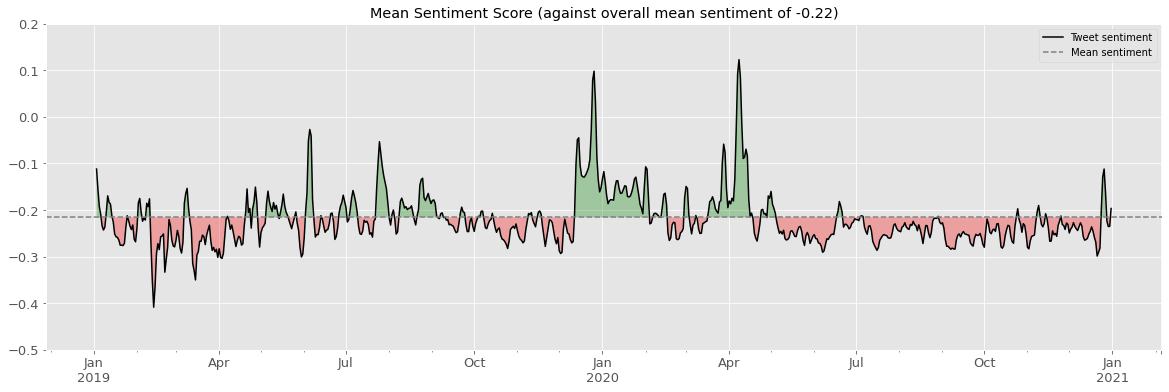

In [8]:
ROLLING = 3
YMAX = 0.2
YMIN = -0.5

ax = sentiment_summary.avg_sentiment.rolling(ROLLING).mean().plot(figsize=(20, 6), color='black', label='Tweet sentiment')
ax.axhline(MEAN_SENTIMENT, color='grey', ls='--', label='Mean sentiment')

ax.fill_between(
    sentiment_summary.index, 
    sentiment_summary.avg_sentiment.rolling(ROLLING).mean(), 
    MEAN_SENTIMENT,
    alpha=0.3,
    where=(sentiment_summary.avg_sentiment.rolling(ROLLING).mean() < MEAN_SENTIMENT),
    facecolor='red'
)
ax.fill_between(
    sentiment_summary.index, 
    MEAN_SENTIMENT,
    sentiment_summary.avg_sentiment.rolling(ROLLING).mean(), 
    alpha=0.3,
    where=(sentiment_summary.avg_sentiment.rolling(ROLLING).mean() >= MEAN_SENTIMENT),
    facecolor='green'
)

ax.set_title('Mean Sentiment Score (against overall mean sentiment of {})'.format(round(MEAN_SENTIMENT, 2), fontsize=16))
ax.set_ylim(YMIN,YMAX)
             
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
             
plt.legend()
plt.savefig('images/mean_sentiment_over_time.png')

plt.show()

## Zoom in on the time period that Boris contracted coronavirus

In [9]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta

from src.sentiment import insert_crosses_zero_points

In [10]:
X_MIN = datetime(2020, 3, 16)  # First UK Lockdown begins
X_1 = datetime(2020, 3, 27)  # Boris tests positive for coronavirus
X_2 = datetime(2020, 4, 5)  # Boris admitted to hospital
X_3 = datetime(2020, 4, 6)  # Boris in intensive care
X_4 = datetime(2020, 4, 12)  # Boris discharged from hospital
X_5 = datetime(2020, 4, 26)  # returns to Downing Street
X_MAX = datetime(2020, 5, 1)  

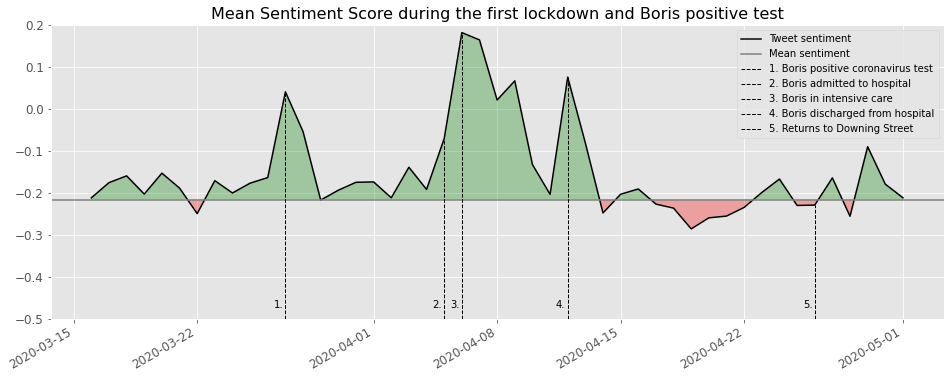

In [11]:
ROLLING = 1
YMAX = 0.2
YMIN = -0.5

ss_filtered = sentiment_summary.loc[
    (sentiment_summary.index >= X_MIN) & (sentiment_summary.index <= X_MAX), 
    'avg_sentiment'
]
ss_filtered = insert_crosses_zero_points(ss_filtered, MEAN_SENTIMENT)

ax = ss_filtered.plot(figsize=(16, 6), color='black', label='Tweet sentiment')
ax.axhline(MEAN_SENTIMENT, color='grey', ls='-', label='Mean sentiment')

ax.fill_between(
    ss_filtered.index, 
    ss_filtered, 
    MEAN_SENTIMENT,
    alpha=0.3,
    where=(ss_filtered <= MEAN_SENTIMENT),
    facecolor='red'
)
ax.fill_between(
    ss_filtered.index,  
    MEAN_SENTIMENT,
    ss_filtered, 
    alpha=0.3,
    where=(ss_filtered >= MEAN_SENTIMENT),
    facecolor='green'
)

ax.axvline(X_1, 0, (ss_filtered[X_1]-YMIN)/(YMAX-YMIN), color='black', linewidth=1, ls='--', label='1. Boris positive coronavirus test')
ax.axvline(X_2, 0, (ss_filtered[X_2]-YMIN)/(YMAX-YMIN), color='black', linewidth=1, ls='--', label='2. Boris admitted to hospital')
ax.axvline(X_3, 0, (ss_filtered[X_3]-YMIN)/(YMAX-YMIN), color='black', linewidth=1, ls='--', label='3. Boris in intensive care')
ax.axvline(X_4, 0, (ss_filtered[X_4]-YMIN)/(YMAX-YMIN), color='black', linewidth=1, ls='--', label='4. Boris discharged from hospital')
ax.axvline(X_5, 0, (ss_filtered[X_5]-YMIN)/(YMAX-YMIN), color='black', linewidth=1, ls='--', label='5. Returns to Downing Street')

ax.text(X_1-relativedelta(hours=16), YMIN+0.025, '1.')
ax.text(X_2-relativedelta(hours=16), YMIN+0.025, '2.')
ax.text(X_3-relativedelta(hours=16), YMIN+0.025, '3.')
ax.text(X_4-relativedelta(hours=16), YMIN+0.025, '4.')
ax.text(X_5-relativedelta(hours=16), YMIN+0.025, '5.')

ax.set_title('Mean Sentiment Score during the first lockdown and Boris positive test', fontsize=16)
ax.set_ylim(YMIN,YMAX)

plt.legend()
             
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
             
plt.savefig('images/Sentiment_first_lockdown_bojo_coronavirus.png')

plt.show()

Notice how there is a large spike in positive tweets immediately after Boris initially tests positive for coronavirus, and also immediately after he is moved to intensive care in the hospital. This is actually the most positive public sentiment has been towards Boris Johnson over the last two years! Lots of these tweets are along the lines of "get well soon". 

Interestingly, sentiment is lower than average when Boris is moved out of hospital to recover in his family home in mid-late April.

## Distribution of sentiment over time

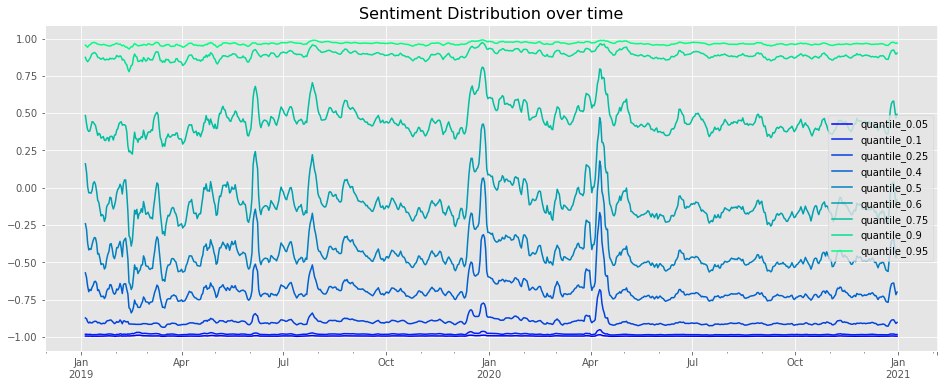

In [12]:
_, ax = plt.subplots(figsize=(16, 6))
sentiment_summary[[x for x in sentiment_summary.columns if x.startswith('quantile_')]]\
    .rolling(5).mean().plot(colormap='winter', ax=ax)
ax.set_title('Sentiment Distribution over time', fontsize=16)
plt.savefig('images/sentiment_distribution.png')
plt.show()

## Stacked bar chart by month

In [16]:
def get_list_of_dates(sdate, edate):
    sdate = datetime.strptime(sdate, '%Y-%m-%d')
    edate = datetime.strptime(edate, '%Y-%m-%d')
    delta = edate - sdate
    dates = [sdate + timedelta(days=i) for i in range(delta.days + 1)]
    return dates

In [17]:
list_of_days = [
    datetime.strptime(get_date_from_file_loc(file_loc), '%Y-%m-%d') 
    for file_loc in os.listdir('tweets_data') if file_loc.endswith('.json')
]
months = {
    year_month: ('{}-01'.format(year_month), (datetime.strptime(year_month, '%Y-%m') + 
                                              relativedelta(months=1) - timedelta(days=1)).strftime('%Y-%m-%d'))
    for year_month in set([
        date.strftime('%Y-%m') for date in list_of_days
    ])
}

In [18]:
bar_chart_data = {}
for month, (sdate, edate) in months.items():
    dates = get_list_of_dates(sdate, edate)
    bar_chart_data[month] = sentiment_summary.loc[
        dates, ['score_-0.9', 'score_-0.7', 'score_0', 'score_0.7', 'score_0.9']
    ].mean().rename(index={'score_-0.9': 'very negative', 'score_-0.7': 'negative',
                          'score_0': 'weak negative', 'score_0.7': 'weak positive',
                           'score_0.9': 'positive'})
    bar_chart_data[month] = bar_chart_data[month].append(pd.Series([1], index=['very positive']))
    bar_chart_data[month] = pd.Series(
        np.where(
            bar_chart_data[month].diff().isnull(), bar_chart_data[month], bar_chart_data[month].diff()
        ),
        index=bar_chart_data[month].index
    )

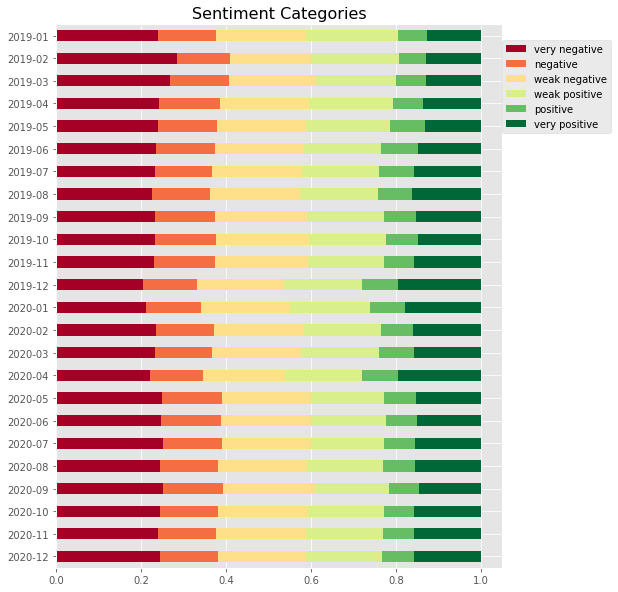

In [19]:
_, ax = plt.subplots(figsize=(8,10))
plot_data = pd.DataFrame(bar_chart_data).T.sort_index(ascending=False)
plot_data.plot(kind='barh', stacked=True, colormap='RdYlGn', ax=ax)
ax.set_title('Sentiment Categories', fontsize=16)
ax.legend(loc=(1,0.8))

plt.savefig('images/sentiment_categories.png', bbox_inches='tight')
plt.show()

## Positive WordCloud vs Negative WordCloud
This might not do very well if the top 100 positive / negative sentences are not reflective of true intent. For example, sentiment scoring models definitely have trouble understanding ___sarcasm___ in text.

In [20]:
from ast import literal_eval
from wordcloud import WordCloud
import random
import itertools

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(40, 96)

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)"  % random.randint(40, 96)

In [21]:
quarters = {
    '2019 Q1': ('2019-01-01', '2019-03-31'),
    '2019 Q2': ('2019-04-01', '2019-06-30'),
    '2019 Q3': ('2019-07-01', '2019-09-30'),
    '2019 Q4': ('2019-10-01', '2019-12-31'),
    '2020 Q1': ('2020-01-01', '2020-03-31'),
    '2020 Q2': ('2020-04-01', '2020-06-30'),
    '2020 Q3': ('2020-07-01', '2020-09-30'),
    '2020 Q4': ('2020-10-01', '2020-12-31'),
}


from wordcloud import STOPWORDS
EXTRA_STOPWORDS = ['will', 'people', 'boris', 'one']
_ = [STOPWORDS.add(n) for n in EXTRA_STOPWORDS]

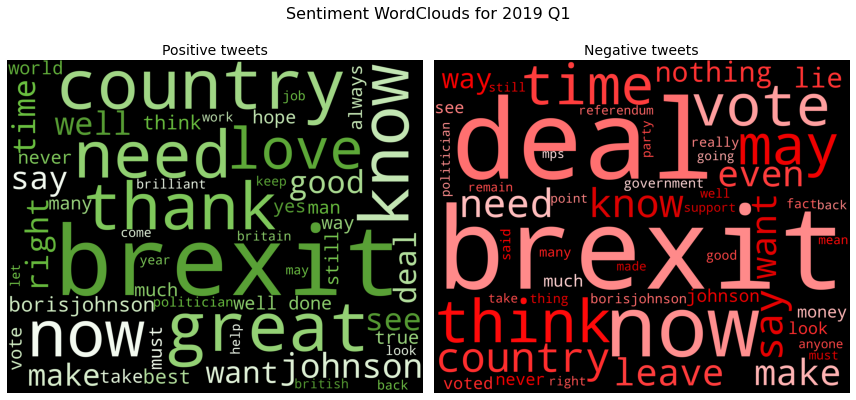

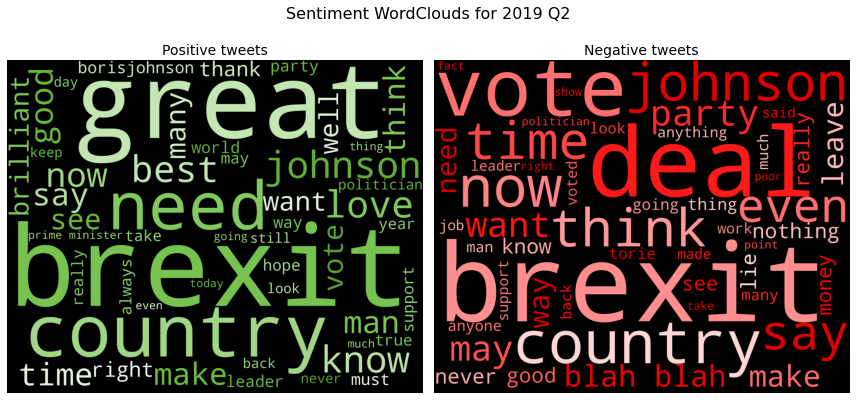

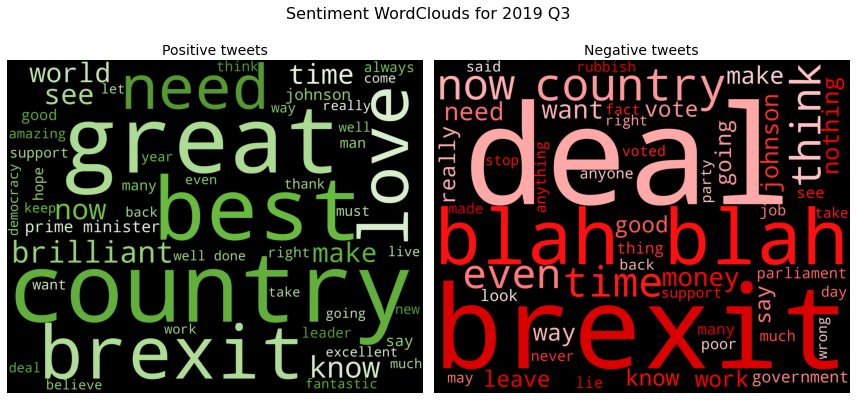

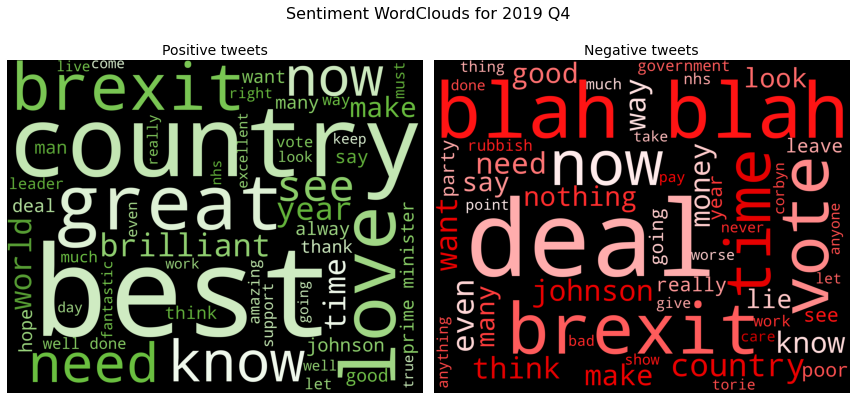

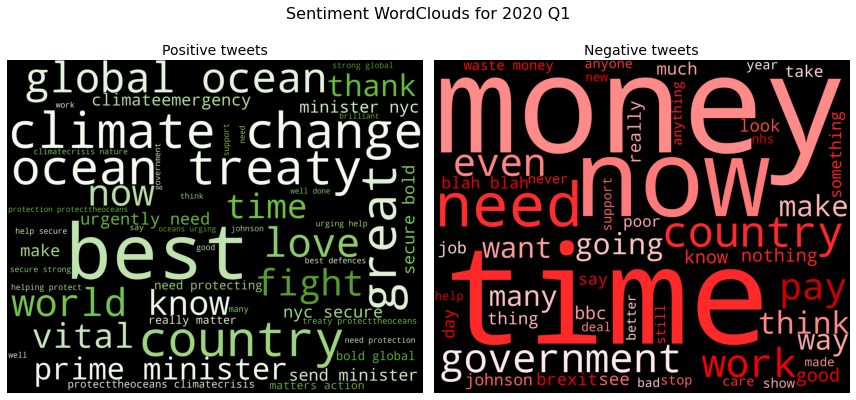

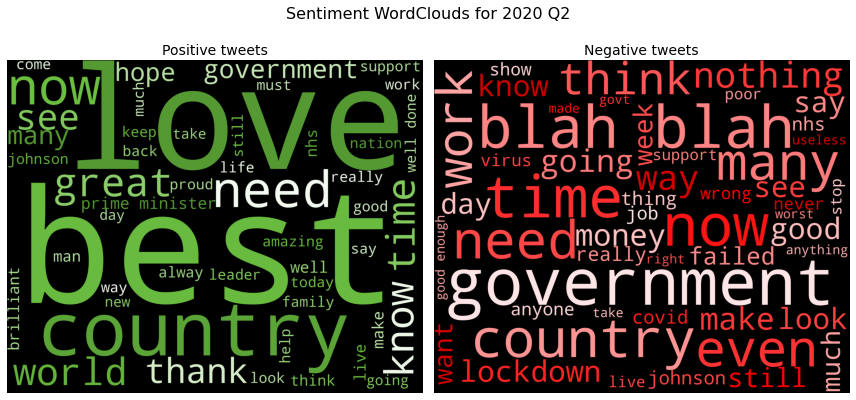

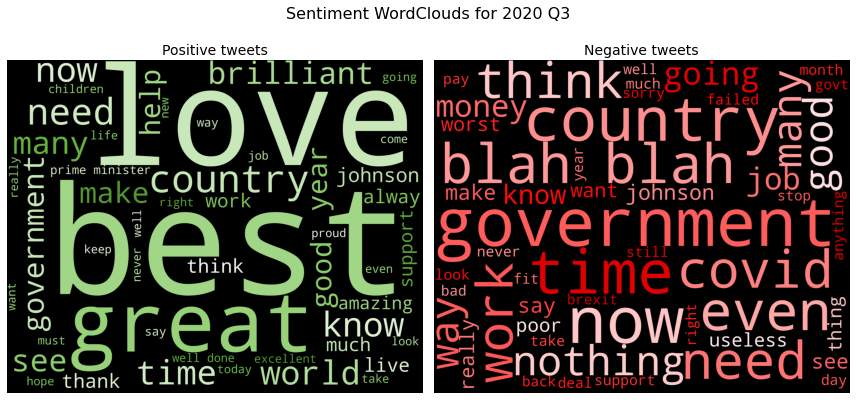

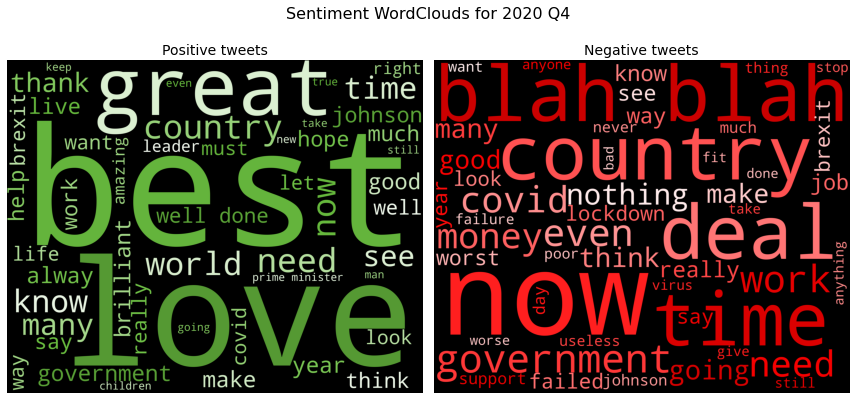

In [22]:
for quarter, (sdate, edate) in quarters.items():
    dates = get_list_of_dates(sdate, edate)

    df = sentiment_summary.loc[dates, ['negative_100', 'positive_100']]
    negative = list(itertools.chain.from_iterable([
        literal_eval(tweet)
        for tweet in df.negative_100
    ]))
    positive = list(itertools.chain.from_iterable([
        literal_eval(tweet)
        for tweet in df.positive_100
    ]))

    negative_txt = ' '.join([x.lower() for x in negative])
    positive_txt = ' '.join([x.lower() for x in positive])

    wcp = WordCloud(
        background_color="black", 
        max_words=50, width=1000, height=800, 
        collocation_threshold=10,
        min_word_length=3,
        scale=3,
        min_font_size=10
    ).generate(positive_txt)
    wcn = WordCloud(
        background_color="black", 
        max_words=50, width=1000, height=800, 
        collocation_threshold=10,
        min_word_length=3,
        scale=3,
        min_font_size=10
    ).generate(negative_txt)

    wcp.recolor(color_func=green_color_func, random_state=1)
    wcn.recolor(color_func=red_color_func, random_state=1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), facecolor=None) 
    ax[0].imshow(wcp) 
    ax[1].imshow(wcn)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Positive tweets', fontsize=14)
    ax[1].set_title('Negative tweets', fontsize=14)

    fig.suptitle('Sentiment WordClouds for {}'.format(quarter), fontsize=16)
    plt.tight_layout()
    plt.savefig('images/Positive_Negative_sentiment_WordCloud_{}.png'.format(quarter.replace(' ', '')))
    plt.show()